### Notebook to Smear G4 data to be continuous, and easier to train

In [8]:
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
#geant4_name = "improved_200cells_FPCD.hdf5"
geant4_name = "../improvedMIP_200cells_FPCD.hdf5"
g4 = h5py.File(geant4_name, 'r')
print(g4.keys())
chunk_size=2000
nevts=100_000

<KeysViewHDF5 ['cluster', 'hcal_cells']>


In [5]:
def get_bin_edges(g4_cell_data):
    centers = np.unique(g4_cell_data)
    if (centers[0] == 0):
        centers = centers[1:]
    width = np.round(centers[1] - centers[0],2)

    edges = centers - width/2
    max_edge = centers[-1] + width/2
    edges = (np.append(edges,max_edge))
    
    return centers, edges

In [6]:
def get_bin_width(g4_cell_data):
    centers = np.unique(g4_cell_data)
    if (centers[0] == 0):
        centers = centers[1:]
        
    width = np.round(centers[1] - centers[0],2)
    
    return width

In [5]:
bin_dict = {}
var_str = ["E","X","Y","Z"]

for var in range(0,4):
    g4_data = g4['hcal_cells'][:nevts,:,var]
    width = get_bin_width(g4_data)
    
    if var == 0:
        width = 2e-5  # 1keV in terms of GeV
    bin_dict[f"width{var_str[var]}"] = width 

print(bin_dict.keys())

dict_keys(['widthE', 'widthX', 'widthY', 'widthZ'])


In [6]:
print((bin_dict["widthE"]))

2e-05


In [7]:
nevents = np.shape(g4['hcal_cells'])[0]
#nevents = 100

ncells = np.shape(g4['hcal_cells'])[1]
nvar = np.shape(g4['hcal_cells'])[2]
ncluster_var = np.shape(g4['cluster'])[1]
chunk_size = 100

with h5py.File(f'newMIP_smeared_20keV_200cells_FPCD.hdf5', 'w') as newfile:
    # create empty data set
    dset = newfile.create_dataset('hcal_cells', 
                                shape=(nevents,ncells,nvar),
                                maxshape=(nevents,ncells,nvar), 
                                chunks=(chunk_size, ncells, nvar),
                                dtype=np.float32)



    cluster_dset = newfile.create_dataset('cluster', data=g4['cluster'])
    
    #MASK = np.where(g4['hcal_cells'][:nevents,:,-1] == 1)
    MASK = g4['hcal_cells'][:nevents,:,-1]
    dset[:nevents,:,-1] = MASK
    for var in range(0,4):
        
        width = bin_dict[f"width{var_str[var]}"]
        g4_data = g4['hcal_cells'][:nevents,:,var]
        smear = np.random.default_rng().uniform(low=-width/2,high=width/2, size=np.shape(g4_data))
        for test in range(10):
            print(f"Width {width}: {g4_data[test,0]} + {smear[test,0]}")
        dset[:nevents,:,var] = (g4_data + smear)*MASK

Width 2e-05: 0.0004150390741415322 + 4.6990508445058993e-07
Width 2e-05: 0.001800537109375 + -6.969914211151736e-06
Width 2e-05: 0.0006164551014080644 + 8.905074108373511e-07
Width 2e-05: 0.0005371093866415322 + -6.3630235298792795e-06
Width 2e-05: 0.0005676269647665322 + 2.208986413052693e-06
Width 2e-05: 0.0004394531133584678 + -9.404825517437735e-06
Width 2e-05: 0.0037353516090661287 + 8.164348647285828e-07
Width 2e-05: 0.000579833984375 + 8.840510119716391e-06
Width 2e-05: 0.0010925292735919356 + -5.184375666847834e-06
Width 2e-05: 0.0013000487815588713 + -3.6400044848608155e-06
Width 100.0: 1000.0 + 8.547537884286285
Width 100.0: -1300.0 + -36.40003176831544
Width 100.0: 1000.0 + 11.413697649052835
Width 100.0: 900.0 + 46.37272303983168
Width 100.0: -700.0 + -31.290632352256743
Width 100.0: -1200.0 + -10.74823408299396
Width 100.0: -900.0 + 28.06837297827697
Width 100.0: 400.0 + 48.682511977218425
Width 100.0: -1300.0 + 13.066723527304127
Width 100.0: -900.0 + -43.55534136468211
W

In [8]:
with h5py.File(f'smeared_20keV_200cells_FPCD.hdf5', 'r') as disc:
    print(disc["hcal_cells"][10,10,:])

[ 4.8840826e-04 -6.3959076e+02  1.0702521e+03  4.0657200e+03
  1.0000000e+00]


In [9]:
print(g4["hcal_cells"][100,:10,3])

[3821.5 3844.9 3868.3 3915.1 3938.5 3938.5 3891.7 3844.9 3868.3 3915.1]


Text(0.5, 1.0, 'genTheta')

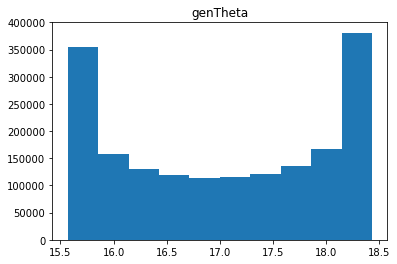

In [12]:
plt.hist(np.ravel(g4['cluster'][:,1]))
plt.title("genTheta")